## This script was developed for:
#### Zhu, F. and B.E.J. Rose. (2022). Multiple Equilibria in a Coupled Climate-Carbon Model. Journal of Climate. DOI: 10.1175/JCLI-D-21-0984.1

Author of the script: *Fangze Zhu*

University at Albany, State University of New York (SUNY)

In [1]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from numpy import dtype
from statistics import median

mitdir = '/nfs/home11/grad/2017/fz172169/MITgcm/utils/python/MITgcmutils'
os.chdir(mitdir)
import MITgcmutils as mit

csdir = '/nfs/home11/grad/2017/fz172169/Documents/my_scripts'
os.chdir(csdir)
from cs import zonalKernel
from cs import zonalAvg

In [2]:
def read_ncfile(filename, varname, index=None):
    ncin = Dataset(filename, 'r', format='NETCDF4')
    if index == None:
        vin = ncin.variables[varname][:]
    else:
        vin = ncin.variables[varname][index]
    return vin

In [3]:
def feedback_parameter_spatial(run, state, index_h, index_l):
    kernel_T_LW = read_ncfile(os.path.join(datadir,'kernel',state,'kernel_T_LW_'+state+'.nc'), 
                              'kernel_T_LW')
    kernel_T_LW_CLR = read_ncfile(os.path.join(datadir,'kernel',state,'kernel_T_LW_CLR_'+state+'.nc'), 
                                  'kernel_T_LW_CLR')
    kernel_surfT_LW = read_ncfile(os.path.join(datadir,'kernel',state,'kernel_surfT_LW_'+state+'.nc'), 
                                  'kernel_surfT_LW')
    kernel_surfT_LW_CLR = read_ncfile(os.path.join(datadir,'kernel',state,'kernel_surfT_LW_CLR_'+state+'.nc'), 
                                      'kernel_surfT_LW_CLR')
    kernel_Q_LW = read_ncfile(os.path.join(datadir,'kernel',state,'kernel_Q_LW_'+state+'.nc'), 
                              'kernel_Q_LW')
    kernel_Q_LW_CLR = read_ncfile(os.path.join(datadir,'kernel',state,'kernel_Q_LW_CLR_'+state+'.nc'), 
                                  'kernel_Q_LW_CLR')
    kernel_Q_SW = read_ncfile(os.path.join(datadir,'kernel',state,'kernel_Q_SW_'+state+'.nc'), 
                              'kernel_Q_SW')
    kernel_Q_SW_CLR = read_ncfile(os.path.join(datadir,'kernel',state,'kernel_Q_SW_CLR_'+state+'.nc'), 
                                  'kernel_Q_SW_CLR')
    kernel_ALB_SW = read_ncfile(os.path.join(datadir,'kernel',state,'kernel_ALB_SW_'+state+'.nc'), 
                                'kernel_ALB_SW')
    kernel_ALB_SW_CLR = read_ncfile(os.path.join(datadir,'kernel',state,'kernel_ALB_SW_CLR_'+state+'.nc'), 
                                    'kernel_ALB_SW_CLR')
    kernel_CO2_LW = read_ncfile(os.path.join(datadir,'kernel',state,'kernel_CO2_LW_'+state+'.nc'), 
                                'kernel_CO2_LW')
    kernel_CO2_LW_CLR = read_ncfile(os.path.join(datadir,'kernel',state,'kernel_CO2_LW_CLR_'+state+'.nc'), 
                                    'kernel_CO2_LW_CLR')
    
    # T 
    delta_TS = read_ncfile(os.path.join(datadir,'time_series',run+'_TS.nc'), 'TS', index_h) - \
               read_ncfile(os.path.join(datadir,'time_series',run+'_TS.nc'), 'TS', index_l)
    delta_T = read_ncfile(os.path.join(datadir,'time_series',run+'_T.nc'), 'T', index_h) - \
              read_ncfile(os.path.join(datadir,'time_series',run+'_T.nc'), 'T', index_l)
    delta_surfT = read_ncfile(os.path.join(datadir,'time_series',run+'_surfT.nc'), 'surfT', index_h) - \
                  read_ncfile(os.path.join(datadir,'time_series',run+'_surfT.nc'), 'surfT', index_l)  
    feedback_T_LW = np.mean(kernel_T_LW*delta_T/delta_TS, axis=0)
    feedback_T_LW_CLR = np.mean(kernel_T_LW_CLR*delta_T/delta_TS, axis=0)
    feedback_surfT_LW = np.mean(kernel_surfT_LW*delta_surfT/delta_TS, axis=0)
    feedback_surfT_LW_CLR = np.mean(kernel_surfT_LW_CLR*delta_surfT/delta_TS, axis=0)
    feedback_P_LW = np.zeros((Z,Y,X))
    feedback_L_LW = np.zeros((Z,Y,X))
    delta_T_minus_surfT = np.zeros((12,Z,Y,X))
    for k in range(Z):
        feedback_P_LW[k,:,:] = np.mean(kernel_T_LW[:,k,:,:]*delta_surfT/delta_TS, axis=0)
        feedback_L_LW[k,:,:] = np.mean(kernel_T_LW[:,k,:,:]*(delta_T[:,k,:,:]-delta_surfT)/delta_TS, axis=0)
        delta_T_minus_surfT[:,k,:,:] = delta_T[:,k,:,:]-delta_surfT
    feedback_integrated_T_LW = np.zeros((Y,X))
    feedback_integrated_T_LW_CLR = np.zeros((Y,X))
    feedback_integrated_P_LW = np.zeros((Y,X))
    feedback_integrated_L_LW = np.zeros((Y,X))
    for j in range(Y):
        for i in range(X):
            feedback_integrated_T_LW[j,i] = np.sum(feedback_T_LW[:,j,i]) + feedback_surfT_LW[j,i]
            feedback_integrated_T_LW_CLR[j,i] = np.sum(feedback_T_LW_CLR[:,j,i]) + feedback_surfT_LW_CLR[j,i]
            feedback_integrated_P_LW[j,i] = np.sum(feedback_P_LW[:,j,i]) + feedback_surfT_LW[j,i]
            feedback_integrated_L_LW[j,i] = np.sum(feedback_L_LW[:,j,i])
            
    # Q
    delta_Q = read_ncfile(os.path.join(datadir,'time_series',run+'_Q.nc'), 'Q', index_h) - \
              read_ncfile(os.path.join(datadir,'time_series',run+'_Q.nc'), 'Q', index_l)
    feedback_Q_LW = np.mean(kernel_Q_LW*delta_Q/delta_TS, axis=0)
    feedback_Q_LW_CLR = np.mean(kernel_Q_LW_CLR*delta_Q/delta_TS, axis=0)
    feedback_Q_SW = np.mean(kernel_Q_SW*delta_Q/delta_TS, axis=0)
    feedback_Q_SW_CLR = np.mean(kernel_Q_SW_CLR*delta_Q/delta_TS, axis=0)
    feedback_integrated_Q_LW = np.zeros((Y,X))
    feedback_integrated_Q_LW_CLR = np.zeros((Y,X))
    feedback_integrated_Q_SW = np.zeros((Y,X))
    feedback_integrated_Q_SW_CLR = np.zeros((Y,X))
    for j in range(Y):
        for i in range(X):
            feedback_integrated_Q_LW[j,i] = np.sum(feedback_Q_LW[:,j,i])
            feedback_integrated_Q_LW_CLR[j,i] = np.sum(feedback_Q_LW_CLR[:,j,i])
            feedback_integrated_Q_SW[j,i] = np.sum(feedback_Q_SW[:,j,i])
            feedback_integrated_Q_SW_CLR[j,i] = np.sum(feedback_Q_SW_CLR[:,j,i])
    
    # ALB
    delta_ALB = read_ncfile(os.path.join(datadir,'time_series',run+'_ALB.nc'), 'ALB', index_h) - \
                read_ncfile(os.path.join(datadir,'time_series',run+'_ALB.nc'), 'ALB', index_l)
    feedback_ALB_SW = np.mean(kernel_ALB_SW*delta_ALB/delta_TS, axis=0)
    feedback_ALB_SW_CLR = np.mean(kernel_ALB_SW_CLR*delta_ALB/delta_TS, axis=0)
    
    # CO2
    delta_CO2 = read_ncfile(os.path.join(datadir,'time_series',run+'_CO2.nc'), 'CO2', index_h) - \
                read_ncfile(os.path.join(datadir,'time_series',run+'_CO2.nc'), 'CO2', index_l)
    feedback_CO2_LW = np.zeros((12,Y,X))
    feedback_CO2_LW_CLR = np.zeros((12,Y,X))
    for mon in range(12):
        feedback_CO2_LW[mon,:,:] = kernel_CO2_LW[mon,:,:]*delta_CO2[mon]/delta_TS
        feedback_CO2_LW_CLR[mon,:,:] = kernel_CO2_LW_CLR[mon,:,:]*delta_CO2[mon]/delta_TS
    feedback_CO2_LW = np.mean(feedback_CO2_LW, axis=0)
    feedback_CO2_LW_CLR = np.mean(feedback_CO2_LW_CLR, axis=0)
    
    # CRF
    OLR_h = read_ncfile(os.path.join(datadir,'time_series',run+'_OLR.nc'), 'OLR', index_h)  
    OLR_l = read_ncfile(os.path.join(datadir,'time_series',run+'_OLR.nc'), 'OLR', index_l)
    OLRCLR_h = read_ncfile(os.path.join(datadir,'time_series',run+'_OLRCLR.nc'), 'OLRCLR', index_h)
    OLRCLR_l = read_ncfile(os.path.join(datadir,'time_series',run+'_OLRCLR.nc'), 'OLRCLR', index_l)
    TSR_h = read_ncfile(os.path.join(datadir,'time_series',run+'_TSR.nc'), 'TSR', index_h)  
    TSR_l = read_ncfile(os.path.join(datadir,'time_series',run+'_TSR.nc'), 'TSR', index_l)
    TSRCLR_h = read_ncfile(os.path.join(datadir,'time_series',run+'_TSRCLR.nc'), 'TSRCLR', index_h)
    TSRCLR_l = read_ncfile(os.path.join(datadir,'time_series',run+'_TSRCLR.nc'), 'TSRCLR', index_l)
    CRF_LW_h = -OLR_h + OLRCLR_h
    CRF_LW_l = -OLR_l + OLRCLR_l
    CRF_SW_h = TSR_h - TSRCLR_h 
    CRF_SW_l = TSR_l - TSRCLR_l    
    delta_CRF_LW = CRF_LW_h - CRF_LW_l
    delta_CRF_SW = CRF_SW_h - CRF_SW_l
    feedback_cld_LW = np.mean(delta_CRF_LW/delta_TS, axis=0) + \
                      feedback_integrated_T_LW_CLR - feedback_integrated_T_LW + \
                      feedback_integrated_Q_LW_CLR - feedback_integrated_Q_LW + \
                      feedback_CO2_LW_CLR - feedback_CO2_LW
    feedback_cld_SW = np.mean(delta_CRF_SW/delta_TS, axis=0) + \
                      feedback_integrated_Q_SW_CLR - feedback_integrated_Q_SW + \
                      feedback_ALB_SW_CLR - feedback_ALB_SW
    delta_CLDCLW = read_ncfile(os.path.join(datadir,'time_series',run+'_CLDCLW.nc'), 'CLDCLW', index_h) - \
                   read_ncfile(os.path.join(datadir,'time_series',run+'_CLDCLW.nc'), 'CLDCLW', index_l)
    
    # annual mean
    delta_T = np.mean(delta_T, axis=0)
    delta_surfT = np.mean(delta_surfT, axis=0)
    delta_T_minus_surfT = np.mean(delta_T_minus_surfT, axis=0)
    delta_Q = np.mean(delta_Q, axis=0)
    delta_ALB = np.mean(delta_ALB, axis=0)
    delta_CO2 = np.mean(delta_CO2, axis=0)
    delta_CRF_LW = np.mean(delta_CRF_LW, axis=0)
    delta_CRF_SW = np.mean(delta_CRF_SW, axis=0)
    delta_CLDCLW = np.mean(delta_CLDCLW, axis=0)
    
    with open(os.path.join(datadir, 'delta', 'spatial_delta_T_' + run + '.data'),"ab") as f:
        f.write(delta_T)
    with open(os.path.join(datadir, 'delta', 'spatial_delta_surfT_' + run + '.data'),"ab") as f:
        f.write(delta_surfT)
    with open(os.path.join(datadir, 'delta', 'spatial_delta_T_minus_surfT_' + run + '.data'),"ab") as f:
        f.write(delta_T_minus_surfT)
    with open(os.path.join(datadir, 'delta', 'spatial_delta_Q_' + run + '.data'),"ab") as f:
        f.write(delta_Q)
    with open(os.path.join(datadir, 'delta', 'spatial_delta_ALB_' + run + '.data'),"ab") as f:
        f.write(delta_ALB)
    with open(os.path.join(datadir, 'delta', 'spatial_delta_CO2_' + run + '.data'),"ab") as f:
        f.write(delta_CO2)
    with open(os.path.join(datadir, 'delta', 'spatial_delta_CRF_LW_' + run + '.data'),"ab") as f:
        f.write(delta_CRF_LW)
    with open(os.path.join(datadir, 'delta', 'spatial_delta_CRF_SW_' + run + '.data'),"ab") as f:
        f.write(delta_CRF_SW)
    with open(os.path.join(datadir, 'delta', 'spatial_delta_CLDCLW_' + run + '.data'),"ab") as f:
        f.write(delta_CLDCLW)
    
    with open(os.path.join(datadir, 'feedback', 'spatial_feedback_T_LW_' + state + '.data'),"ab") as f:
        f.write(feedback_T_LW)
    with open(os.path.join(datadir, 'feedback', 'spatial_feedback_P_LW_' + state + '.data'),"ab") as f:
        f.write(feedback_P_LW)
    with open(os.path.join(datadir, 'feedback', 'spatial_feedback_L_LW_' + state + '.data'),"ab") as f:
        f.write(feedback_L_LW)
    with open(os.path.join(datadir, 'feedback', 'spatial_feedback_surfT_LW_' + state + '.data'),"ab") as f:
        f.write(feedback_surfT_LW)
    with open(os.path.join(datadir, 'feedback', 'spatial_feedback_Q_LW_' + state + '.data'),"ab") as f:
        f.write(feedback_Q_LW)
    with open(os.path.join(datadir, 'feedback', 'spatial_feedback_Q_SW_' + state + '.data'),"ab") as f:
        f.write(feedback_Q_SW)
    with open(os.path.join(datadir, 'feedback', 'spatial_feedback_ALB_SW_' + state + '.data'),"ab") as f:
        f.write(feedback_ALB_SW)
    with open(os.path.join(datadir, 'feedback', 'spatial_feedback_CO2_LW_' + state + '.data'),"ab") as f:
        f.write(feedback_CO2_LW)
    with open(os.path.join(datadir, 'feedback', 'spatial_feedback_cld_LW_' + state + '.data'),"ab") as f:
        f.write(feedback_cld_LW)
    with open(os.path.join(datadir, 'feedback', 'spatial_feedback_cld_SW_' + state + '.data'),"ab") as f:
        f.write(feedback_cld_SW)

In [4]:
def feedback_parameter_spatial_CLR(run, state, index_h, index_l):
    kernel_T_LW_CLR = read_ncfile(os.path.join(datadir,'kernel',state,'kernel_T_LW_CLR_'+state+'.nc'), 
                                  'kernel_T_LW_CLR')
    kernel_surfT_LW_CLR = read_ncfile(os.path.join(datadir,'kernel',state,'kernel_surfT_LW_CLR_'+state+'.nc'), 
                                      'kernel_surfT_LW_CLR')
    kernel_Q_SW_CLR = read_ncfile(os.path.join(datadir,'kernel',state,'kernel_Q_SW_CLR_'+state+'.nc'), 
                                  'kernel_Q_SW_CLR')
    kernel_ALB_SW_CLR = read_ncfile(os.path.join(datadir,'kernel',state,'kernel_ALB_SW_CLR_'+state+'.nc'), 
                                    'kernel_ALB_SW_CLR')
    
    # T 
    delta_TS = read_ncfile(os.path.join(datadir,'time_series',run+'_TS.nc'), 'TS', index_h) - \
               read_ncfile(os.path.join(datadir,'time_series',run+'_TS.nc'), 'TS', index_l)
    delta_T = read_ncfile(os.path.join(datadir,'time_series',run+'_T.nc'), 'T', index_h) - \
              read_ncfile(os.path.join(datadir,'time_series',run+'_T.nc'), 'T', index_l)
    delta_surfT = read_ncfile(os.path.join(datadir,'time_series',run+'_surfT.nc'), 'surfT', index_h) - \
                  read_ncfile(os.path.join(datadir,'time_series',run+'_surfT.nc'), 'surfT', index_l)  
    feedback_T_LW_CLR = np.mean(kernel_T_LW_CLR*delta_T/delta_TS, axis=0)
    feedback_surfT_LW_CLR = np.mean(kernel_surfT_LW_CLR*delta_surfT/delta_TS, axis=0)
    feedback_P_LW_CLR = np.zeros((Z,Y,X))
    feedback_L_LW_CLR = np.zeros((Z,Y,X))
    for k in range(Z):
        feedback_P_LW_CLR[k,:,:] = np.mean(kernel_T_LW_CLR[:,k,:,:]*delta_surfT/delta_TS, axis=0)
        feedback_L_LW_CLR[k,:,:] = np.mean(kernel_T_LW_CLR[:,k,:,:]*(delta_T[:,k,:,:]-delta_surfT)/delta_TS, 
                                           axis=0)
    #feedback_integrated_T_LW_CLR = np.zeros((Y,X))
    #for j in range(Y):
    #    for i in range(X):
    #        feedback_integrated_T_LW_CLR[j,i] = np.sum(feedback_T_LW_CLR[:,j,i]) + feedback_surfT_LW_CLR[j,i]
            
    # Q
    delta_Q = read_ncfile(os.path.join(datadir,'time_series',run+'_Q.nc'), 'Q', index_h) - \
              read_ncfile(os.path.join(datadir,'time_series',run+'_Q.nc'), 'Q', index_l)
    feedback_Q_SW_CLR = np.mean(kernel_Q_SW_CLR*delta_Q/delta_TS, axis=0)
    #feedback_integrated_Q_SW_CLR = np.zeros((Y,X))
    #for j in range(Y):
    #    for i in range(X):
    #        feedback_integrated_Q_SW_CLR[j,i] = np.sum(feedback_Q_SW_CLR[:,j,i])
    
    # ALB
    delta_ALB = read_ncfile(os.path.join(datadir,'time_series',run+'_ALB.nc'), 'ALB', index_h) - \
                read_ncfile(os.path.join(datadir,'time_series',run+'_ALB.nc'), 'ALB', index_l)
    feedback_ALB_SW_CLR = np.mean(kernel_ALB_SW_CLR*delta_ALB/delta_TS, axis=0)

    
    with open(os.path.join(datadir, 'feedback', 'spatial_feedback_T_LW_CLR_' + state + '.data'),"ab") as f:
        f.write(feedback_T_LW_CLR)
    with open(os.path.join(datadir, 'feedback', 'spatial_feedback_P_LW_CLR_' + state + '.data'),"ab") as f:
        f.write(feedback_P_LW_CLR)
    with open(os.path.join(datadir, 'feedback', 'spatial_feedback_L_LW_CLR_' + state + '.data'),"ab") as f:
        f.write(feedback_L_LW_CLR)
    with open(os.path.join(datadir, 'feedback', 'spatial_feedback_surfT_LW_CLR_' + state + '.data'),"ab") as f:
        f.write(feedback_surfT_LW_CLR)
    with open(os.path.join(datadir, 'feedback', 'spatial_feedback_Q_SW_CLR_' + state + '.data'),"ab") as f:
        f.write(feedback_Q_SW_CLR)
    with open(os.path.join(datadir, 'feedback', 'spatial_feedback_ALB_SW_CLR_' + state + '.data'),"ab") as f:
        f.write(feedback_ALB_SW_CLR)

## Start

In [5]:
exp_warm = [#'warm_test16_1050',
            'warm_test16_1250',
            ]
exp_cold = [#'cold_800',
            'cold_950',
            ]
exp_waterbelt = [#'waterbelt_500',
                 'waterbelt_550',
                 ]

run_list_warm = ['radCO2_warm_pco2']
run_list_cold = ['radCO2_pC200_SC338_cold']
run_list_waterbelt = ['radCO2_waterbelt_pco2']

plot_list = [#'delta_TS',
             'kernel_T_LW',
             'kernel_surfT_LW',
             'delta_T',
             'delta_surfT',
             'delta_T_minus_surfT',
             'feedback_T_LW',
             'feedback_P_LW',
             'feedback_L_LW',
             'feedback_surfT_LW',
             'kernel_Q_LW',
             'delta_Q',
             'feedback_Q_LW',
             'kernel_Q_SW',
             'feedback_Q_SW',
             'kernel_ALB_SW',
             'delta_ALB',
             'feedback_ALB_SW',
             'kernel_CO2_LW',
             #'delta_CO2',
             'feedback_CO2_LW',
             'delta_CLDCLW',
             #'delta_CRF_LW',
             #'feedback_cld_LW',
             #'delta_CRF_SW',
             #'feedback_cld_SW',
            ]

In [6]:
dir = '/nfs/roselab_rit/mitgcm_run'
rundir = os.path.join(dir, 'kernel')
outdir = '/nfs/roselab_rit/mitgcm_output/global_fric'
datadir = '/nfs/roselab_rit/mitgcm_output/kernel_data'

grid_atm = mit.rdmnc(os.path.join(dir,'radCO2_warm_pco2','out/Cpl1/GridAtm/grid.*'))   # Read the grid
global_area = np.sum(grid_atm['rA'])
X = len(grid_atm['X'])
Y = len(grid_atm['Y'])
Z = len(grid_atm['Z'])
P = grid_atm['Z']

## Export spacial feedback and delta

In [ ]:
low1 = 751
low2 = 850
high1 = 1151
high2 = 1250
for run in run_list_warm:
    for state in exp_warm:
        for index_l in range(low1,low2):
            for index_h in range(high1,high2):
                print(index_l,index_h)
                feedback_parameter_spatial(run, state, index_h, index_l)

In [ ]:
low1 = 751
low2 = 850
high1 = 1151
high2 = 1250
for run in run_list_warm:
    for state in exp_warm:
        for index_l in range(low1,low2):
            for index_h in range(high1,high2):
                print(index_l,index_h)
                feedback_parameter_spatial_CLR(run, state, index_h, index_l)

In [ ]:
low1 = 1
low2 = 100
high1 = 101
high2 = 200
ntime = (low2-low1)*(high2-high1)
for run in run_list_cold:
    for state in exp_cold:
        for index_l in range(low1,low2):
            for index_h in range(high1,high2):
                print(index_l,index_h)
                feedback_parameter_spatial(run, state, index_h, index_l)

In [ ]:
low1 = 1
low2 = 100
high1 = 101
high2 = 200
ntime = (low2-low1)*(high2-high1)
for run in run_list_cold:
    for state in exp_cold:
        for index_l in range(low1,low2):
            for index_h in range(high1,high2):
                print(index_l,index_h)
                feedback_parameter_spatial_CLR(run, state, index_h, index_l)

In [ ]:
low1 = 51
low2 = 150
high1 = 151
high2 = 250
ntime = (low2-low1)*(high2-high1)
for run in run_list_waterbelt:
    for state in exp_waterbelt:
        for index_l in range(low1,low2):
            for index_h in range(high1,high2):
                print(index_l,index_h)
                feedback_parameter_spatial(run, state, index_h, index_l)

In [ ]:
low1 = 51
low2 = 150
high1 = 151
high2 = 250
ntime = (low2-low1)*(high2-high1)
for run in run_list_waterbelt:
    for state in exp_waterbelt:
        for index_l in range(low1,low2):
            for index_h in range(high1,high2):
                print(index_l,index_h)
                feedback_parameter_spatial_CLR(run, state, index_h, index_l)

In [8]:
low1 = 751
low2 = 850
high1 = 1151
high2 = 1250
for run in run_list_warm:
    for index_l in range(low1,low2):
        for index_h in range(high1,high2):
            delta_TS = read_ncfile(os.path.join(datadir,'time_series',run+'_TS.nc'), 'TS', index_h) - \
                       read_ncfile(os.path.join(datadir,'time_series',run+'_TS.nc'), 'TS', index_l)
            with open(os.path.join(datadir, 'delta', 'delta_TS_' + run + '.data'),"ab") as f:
                f.write(delta_TS)

In [9]:
low1 = 1
low2 = 100
high1 = 101
high2 = 200
for run in run_list_cold:
    for index_l in range(low1,low2):
        for index_h in range(high1,high2):
            delta_TS = read_ncfile(os.path.join(datadir,'time_series',run+'_TS.nc'), 'TS', index_h) - \
                       read_ncfile(os.path.join(datadir,'time_series',run+'_TS.nc'), 'TS', index_l)
            with open(os.path.join(datadir, 'delta', 'delta_TS_' + run + '.data'),"ab") as f:
                f.write(delta_TS)

In [10]:
low1 = 51
low2 = 150
high1 = 151
high2 = 250
for run in run_list_waterbelt:
    for index_l in range(low1,low2):
        for index_h in range(high1,high2):
            delta_TS = read_ncfile(os.path.join(datadir,'time_series',run+'_TS.nc'), 'TS', index_h) - \
                       read_ncfile(os.path.join(datadir,'time_series',run+'_TS.nc'), 'TS', index_l)
            with open(os.path.join(datadir, 'delta', 'delta_TS_' + run + '.data'),"ab") as f:
                f.write(delta_TS)

## Mean of 3-D spatial feedbacks

In [12]:
plist = {}
ntime = 99*99
#==============
#percent = 0.1
#percent = 0.15
percent = 0.25
#==============
lind = int(ntime*percent)
hind = ntime-lind
run_list = ['radCO2_warm_pco2','radCO2_pC200_SC338_cold','radCO2_waterbelt_pco2']
exp_list = ['warm_test16_1250','cold_950','waterbelt_550']
for ind in range(3):
    run = run_list[ind]
    exp = exp_list[ind]

    plist[exp+'kernel_T_LW'] = np.mean(read_ncfile(os.path.join(datadir,'kernel',exp,
                               'kernel_T_LW_'+exp+'.nc'), 'kernel_T_LW'), axis=0)
    plist[exp+'kernel_surfT_LW'] = np.mean(read_ncfile(os.path.join(datadir,'kernel',exp,
                                   'kernel_surfT_LW_'+exp+'.nc'), 'kernel_surfT_LW'), axis=0)
    plist[exp+'kernel_Q_LW'] = np.mean(read_ncfile(os.path.join(datadir,'kernel',exp,
                               'kernel_Q_LW_'+exp+'.nc'), 'kernel_Q_LW'), axis=0)
    plist[exp+'kernel_Q_SW'] = np.mean(read_ncfile(os.path.join(datadir,'kernel',exp,
                               'kernel_Q_SW_'+exp+'.nc'), 'kernel_Q_SW'), axis=0)
    plist[exp+'kernel_ALB_SW'] = np.mean(read_ncfile(os.path.join(datadir,'kernel',exp,
                                 'kernel_ALB_SW_'+exp+'.nc'), 'kernel_ALB_SW'), axis=0)
    plist[exp+'kernel_CO2_LW'] = np.mean(read_ncfile(os.path.join(datadir,'kernel',exp,
                                 'kernel_CO2_LW_'+exp+'.nc'), 'kernel_CO2_LW'), axis=0)

    with open(os.path.join(datadir,'delta','spatial_delta_T_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z,Y,X)
        for k in range(Z):
            for j in range(Y):
                for i in range(X):
                    x[:,k,j,i].sort()
        plist[exp+'delta_T'] = np.mean(x[lind:hind], axis=0)
    with open(os.path.join(datadir,'delta','spatial_delta_surfT_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        for j in range(Y):
            for i in range(X):
                x[:,j,i].sort()
        plist[exp+'delta_surfT'] = np.mean(x[lind:hind], axis=0)
    with open(os.path.join(datadir,'delta','spatial_delta_T_minus_surfT_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z,Y,X)
        for k in range(Z):
            for j in range(Y):
                for i in range(X):
                    x[:,k,j,i].sort()
        plist[exp+'delta_T_minus_surfT'] = np.mean(x[lind:hind], axis=0)
    with open(os.path.join(datadir,'delta','spatial_delta_Q_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z-1,Y,X)
        for k in range(Z-1):
            for j in range(Y):
                for i in range(X):
                    x[:,k,j,i].sort()
        plist[exp+'delta_Q'] = np.mean(x[lind:hind], axis=0)
    with open(os.path.join(datadir,'delta','spatial_delta_ALB_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        for j in range(Y):
            for i in range(X):
                x[:,j,i].sort()
        plist[exp+'delta_ALB'] = np.mean(x[lind:hind], axis=0)
    with open(os.path.join(datadir,'delta','spatial_delta_CO2_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.sort()
        plist[exp+'delta_CO2'] = np.mean(x[lind:hind], axis=0)
    with open(os.path.join(datadir,'delta','spatial_delta_CLDCLW_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z,Y,X)
        for k in range(Z):
            for j in range(Y):
                for i in range(X):
                    x[:,k,j,i].sort()
        plist[exp+'delta_CLDCLW'] = np.mean(x[lind:hind], axis=0)
    with open(os.path.join(datadir,'delta','spatial_delta_CRF_LW_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        for j in range(Y):
            for i in range(X):
                x[:,j,i].sort()
        plist[exp+'delta_CRF_LW'] = np.mean(x[lind:hind], axis=0)
    with open(os.path.join(datadir,'delta','spatial_delta_CRF_SW_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        for j in range(Y):
            for i in range(X):
                x[:,j,i].sort()
        plist[exp+'delta_CRF_SW'] = np.mean(x[lind:hind], axis=0)

    with open(os.path.join(datadir,'feedback','spatial_feedback_T_LW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z,Y,X)
        for k in range(Z):
            for j in range(Y):
                for i in range(X):
                    x[:,k,j,i].sort()
        plist[exp+'feedback_T_LW'] = np.mean(x[lind:hind], axis=0)
    with open(os.path.join(datadir,'feedback','spatial_feedback_P_LW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z,Y,X)
        for k in range(Z):
            for j in range(Y):
                for i in range(X):
                    x[:,k,j,i].sort()
        plist[exp+'feedback_P_LW'] = np.mean(x[lind:hind], axis=0)
    with open(os.path.join(datadir,'feedback','spatial_feedback_L_LW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z,Y,X)
        for k in range(Z):
            for j in range(Y):
                for i in range(X):
                    x[:,k,j,i].sort()
        plist[exp+'feedback_L_LW'] = np.mean(x[lind:hind], axis=0)
    with open(os.path.join(datadir,'feedback','spatial_feedback_surfT_LW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        for j in range(Y):
            for i in range(X):
                x[:,j,i].sort()
        plist[exp+'feedback_surfT_LW'] = np.mean(x[lind:hind], axis=0)
    with open(os.path.join(datadir,'feedback','spatial_feedback_Q_LW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z-1,Y,X)
        for k in range(Z-1):
            for j in range(Y):
                for i in range(X):
                    x[:,k,j,i].sort()
        plist[exp+'feedback_Q_LW'] = np.mean(x[lind:hind], axis=0)
    with open(os.path.join(datadir,'feedback','spatial_feedback_Q_SW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z-1,Y,X)
        for k in range(Z-1):
            for j in range(Y):
                for i in range(X):
                    x[:,k,j,i].sort()
        plist[exp+'feedback_Q_SW'] = np.mean(x[lind:hind], axis=0)
    with open(os.path.join(datadir,'feedback','spatial_feedback_ALB_SW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        for j in range(Y):
            for i in range(X):
                x[:,j,i].sort()
        plist[exp+'feedback_ALB_SW'] = np.mean(x[lind:hind], axis=0)
    with open(os.path.join(datadir,'feedback','spatial_feedback_CO2_LW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        for j in range(Y):
            for i in range(X):
                x[:,j,i].sort()
        plist[exp+'feedback_CO2_LW'] = np.mean(x[lind:hind], axis=0)
    with open(os.path.join(datadir,'feedback','spatial_feedback_cld_LW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        for j in range(Y):
            for i in range(X):
                x[:,j,i].sort()
        plist[exp+'feedback_cld_LW'] = np.mean(x[lind:hind], axis=0)
    with open(os.path.join(datadir,'feedback','spatial_feedback_cld_SW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        for j in range(Y):
            for i in range(X):
                x[:,j,i].sort()
        plist[exp+'feedback_cld_SW'] = np.mean(x[lind:hind], axis=0)

## Median of 3-D spatial feedbacks

In [13]:
run_list = ['radCO2_warm_pco2','radCO2_pC200_SC338_cold','radCO2_waterbelt_pco2']
for run in run_list:
    with open(os.path.join(datadir,'delta','delta_TS_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        print(median(x))

0.03425364016140975
0.18370459080296087
-0.029850911773138478


In [14]:
plist = {}
ntime = 99*99
run_list = ['radCO2_warm_pco2','radCO2_pC200_SC338_cold','radCO2_waterbelt_pco2']
exp_list = ['warm_test16_1250','cold_950','waterbelt_550']
for ind in range(3):
    run = run_list[ind]
    exp = exp_list[ind]

    plist[exp+'kernel_T_LW'] = np.mean(read_ncfile(os.path.join(datadir,'kernel',exp,
                               'kernel_T_LW_'+exp+'.nc'), 'kernel_T_LW'), axis=0)
    plist[exp+'kernel_surfT_LW'] = np.mean(read_ncfile(os.path.join(datadir,'kernel',exp,
                                   'kernel_surfT_LW_'+exp+'.nc'), 'kernel_surfT_LW'), axis=0)
    plist[exp+'kernel_Q_LW'] = np.mean(read_ncfile(os.path.join(datadir,'kernel',exp,
                               'kernel_Q_LW_'+exp+'.nc'), 'kernel_Q_LW'), axis=0)
    plist[exp+'kernel_Q_SW'] = np.mean(read_ncfile(os.path.join(datadir,'kernel',exp,
                               'kernel_Q_SW_'+exp+'.nc'), 'kernel_Q_SW'), axis=0)
    plist[exp+'kernel_ALB_SW'] = np.mean(read_ncfile(os.path.join(datadir,'kernel',exp,
                                 'kernel_ALB_SW_'+exp+'.nc'), 'kernel_ALB_SW'), axis=0)
    plist[exp+'kernel_CO2_LW'] = np.mean(read_ncfile(os.path.join(datadir,'kernel',exp,
                                 'kernel_CO2_LW_'+exp+'.nc'), 'kernel_CO2_LW'), axis=0)

    with open(os.path.join(datadir,'delta','delta_TS_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        plist[exp+'delta_TS'] = median(x)
    with open(os.path.join(datadir,'delta','spatial_delta_T_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z,Y,X)
        plist[exp+'delta_T'] = np.zeros((Z,Y,X))
        for k in range(Z):
            for j in range(Y):
                for i in range(X):
                    plist[exp+'delta_T'][k,j,i] = median(x[:,k,j,i])/plist[exp+'delta_TS']
    with open(os.path.join(datadir,'delta','spatial_delta_surfT_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        plist[exp+'delta_surfT'] = np.zeros((Y,X))
        for j in range(Y):
            for i in range(X):
                plist[exp+'delta_surfT'][j,i] = median(x[:,j,i])/plist[exp+'delta_TS']
    with open(os.path.join(datadir,'delta','spatial_delta_T_minus_surfT_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z,Y,X)
        plist[exp+'delta_T_minus_surfT'] = np.zeros((Z,Y,X))
        for k in range(Z):
            for j in range(Y):
                for i in range(X):
                    plist[exp+'delta_T_minus_surfT'][k,j,i] = median(x[:,k,j,i])/plist[exp+'delta_TS']
    with open(os.path.join(datadir,'delta','spatial_delta_Q_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z-1,Y,X)
        plist[exp+'delta_Q'] = np.zeros((Z-1,Y,X))
        for k in range(Z-1):
            for j in range(Y):
                for i in range(X):
                    plist[exp+'delta_Q'][k,j,i] = median(x[:,k,j,i])/plist[exp+'delta_TS']
    with open(os.path.join(datadir,'delta','spatial_delta_ALB_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        plist[exp+'delta_ALB'] = np.zeros((Y,X))
        for j in range(Y):
            for i in range(X):
                plist[exp+'delta_ALB'][j,i] = median(x[:,j,i])/plist[exp+'delta_TS']
    with open(os.path.join(datadir,'delta','spatial_delta_CO2_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        plist[exp+'delta_CO2'] = median(x)/plist[exp+'delta_TS']
    with open(os.path.join(datadir,'delta','spatial_delta_CLDCLW_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z,Y,X)
        plist[exp+'delta_CLDCLW'] = np.zeros((Z,Y,X))
        for k in range(Z):
            for j in range(Y):
                for i in range(X):
                    plist[exp+'delta_CLDCLW'][k,j,i] = median(x[:,k,j,i])/plist[exp+'delta_TS']
    with open(os.path.join(datadir,'delta','spatial_delta_CRF_LW_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        plist[exp+'delta_CRF_LW'] = np.zeros((Y,X))
        for j in range(Y):
            for i in range(X):
                plist[exp+'delta_CRF_LW'][j,i] = median(x[:,j,i])/plist[exp+'delta_TS']
    with open(os.path.join(datadir,'delta','spatial_delta_CRF_SW_'+run+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        plist[exp+'delta_CRF_SW'] = np.zeros((Y,X))
        for j in range(Y):
            for i in range(X):
                plist[exp+'delta_CRF_SW'][j,i] = median(x[:,j,i])/plist[exp+'delta_TS']

    with open(os.path.join(datadir,'feedback','spatial_feedback_T_LW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z,Y,X)
        plist[exp+'feedback_T_LW'] = np.zeros((Z,Y,X))
        for k in range(Z):
            for j in range(Y):
                for i in range(X):
                    plist[exp+'feedback_T_LW'][k,j,i] = median(x[:,k,j,i])
    with open(os.path.join(datadir,'feedback','spatial_feedback_P_LW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z,Y,X)
        plist[exp+'feedback_P_LW'] = np.zeros((Z,Y,X))
        for k in range(Z):
            for j in range(Y):
                for i in range(X):
                    plist[exp+'feedback_P_LW'][k,j,i] = median(x[:,k,j,i])
    with open(os.path.join(datadir,'feedback','spatial_feedback_L_LW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z,Y,X)
        plist[exp+'feedback_L_LW'] = np.zeros((Z,Y,X))
        for k in range(Z):
            for j in range(Y):
                for i in range(X):
                    plist[exp+'feedback_L_LW'][k,j,i] = median(x[:,k,j,i])
    with open(os.path.join(datadir,'feedback','spatial_feedback_surfT_LW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        plist[exp+'feedback_surfT_LW'] = np.zeros((Y,X))
        for j in range(Y):
            for i in range(X):
                plist[exp+'feedback_surfT_LW'][j,i] = median(x[:,j,i])
    with open(os.path.join(datadir,'feedback','spatial_feedback_Q_LW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z-1,Y,X)
        plist[exp+'feedback_Q_LW'] = np.zeros((Z-1,Y,X))
        for k in range(Z-1):
            for j in range(Y):
                for i in range(X):
                    plist[exp+'feedback_Q_LW'][k,j,i] = median(x[:,k,j,i])
    with open(os.path.join(datadir,'feedback','spatial_feedback_Q_SW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Z-1,Y,X)
        plist[exp+'feedback_Q_SW'] = np.zeros((Z-1,Y,X))
        for k in range(Z-1):
            for j in range(Y):
                for i in range(X):
                    plist[exp+'feedback_Q_SW'][k,j,i] = median(x[:,k,j,i])
    with open(os.path.join(datadir,'feedback','spatial_feedback_ALB_SW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        plist[exp+'feedback_ALB_SW'] = np.zeros((Y,X))
        for j in range(Y):
            for i in range(X):
                plist[exp+'feedback_ALB_SW'][j,i] = median(x[:,j,i])
    with open(os.path.join(datadir,'feedback','spatial_feedback_CO2_LW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        plist[exp+'feedback_CO2_LW'] = np.zeros((Y,X))
        for j in range(Y):
            for i in range(X):
                plist[exp+'feedback_CO2_LW'][j,i] = median(x[:,j,i])
    with open(os.path.join(datadir,'feedback','spatial_feedback_cld_LW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        plist[exp+'feedback_cld_LW'] = np.zeros((Y,X))
        for j in range(Y):
            for i in range(X):
                plist[exp+'feedback_cld_LW'][j,i] = median(x[:,j,i])
    with open(os.path.join(datadir,'feedback','spatial_feedback_cld_SW_'+exp+'.data'), 'rb') as f:
        x = np.fromfile(f)
        x.resize(ntime,Y,X)
        plist[exp+'feedback_cld_SW'] = np.zeros((Y,X))
        for j in range(Y):
            for i in range(X):
                plist[exp+'feedback_cld_SW'][j,i] = median(x[:,j,i])

## 1-D (zonal-averaged and vertical-integrated) feedbacks

In [15]:
# Based on the median of 3-D spatial feedbacks

run_list = ['radCO2_warm_pco2','radCO2_pC200_SC338_cold','radCO2_waterbelt_pco2']
exp_list = ['warm_test16_1250','cold_950','waterbelt_550']

for exp in exp_list:
    plist[exp+'feedback_integrated_P_LW'] = np.zeros((Y,X))
    plist[exp+'feedback_integrated_L_LW'] = np.zeros((Y,X))
    plist[exp+'feedback_integrated_Q_LW'] = np.zeros((Y,X))
    plist[exp+'feedback_integrated_Q_SW'] = np.zeros((Y,X))
    plist[exp+'feedback_integrated_L+Q_LW'] = np.zeros((Y,X))
    plist[exp+'feedback_integrated_LW'] = np.zeros((Y,X))
    plist[exp+'feedback_integrated_SW'] = np.zeros((Y,X))
    plist[exp+'feedback_integrated_net'] = np.zeros((Y,X))
    for j in range(Y):
        for i in range(X):
            plist[exp+'feedback_integrated_P_LW'][j,i] = np.sum(plist[exp+'feedback_P_LW'][:,j,i]) + \
                                                         plist[exp+'feedback_surfT_LW'][j,i]
            plist[exp+'feedback_integrated_L_LW'][j,i] = np.sum(plist[exp+'feedback_L_LW'][:,j,i])
            plist[exp+'feedback_integrated_Q_LW'][j,i] = np.sum(plist[exp+'feedback_Q_LW'][:,j,i])
            plist[exp+'feedback_integrated_Q_SW'][j,i] = np.sum(plist[exp+'feedback_Q_SW'][:,j,i])
            plist[exp+'feedback_integrated_L+Q_LW'][j,i] = plist[exp+'feedback_integrated_L_LW'][j,i] + \
                                                           plist[exp+'feedback_integrated_Q_LW'][j,i]
            plist[exp+'feedback_integrated_LW'][j,i] = plist[exp+'feedback_integrated_P_LW'][j,i] + \
                                                       plist[exp+'feedback_integrated_L_LW'][j,i] + \
                                                       plist[exp+'feedback_integrated_Q_LW'][j,i] + \
                                                       plist[exp+'feedback_CO2_LW'][j,i] + \
                                                       plist[exp+'feedback_cld_LW'][j,i]
            plist[exp+'feedback_integrated_SW'][j,i] = plist[exp+'feedback_integrated_Q_SW'][j,i] + \
                                                       plist[exp+'feedback_ALB_SW'][j,i] + \
                                                       plist[exp+'feedback_cld_SW'][j,i]
            plist[exp+'feedback_integrated_net'][j,i] = plist[exp+'feedback_integrated_LW'][j,i] + \
                                                        plist[exp+'feedback_integrated_SW'][j,i]

In [16]:
oned_list_LW = ['feedback_integrated_P_LW',
                'feedback_integrated_L+Q_LW',
                'feedback_integrated_L_LW',
                'feedback_integrated_Q_LW',
                'feedback_CO2_LW',
                'feedback_cld_LW',
                'feedback_integrated_LW',
               ]
oned_list_SW = ['feedback_cld_SW',
                'feedback_integrated_Q_SW',
                'feedback_ALB_SW',
                'feedback_integrated_SW',
               ]
oned_list_net = ['feedback_integrated_LW',
                 'feedback_integrated_SW',
                 'feedback_integrated_net',
                ]
oned_list = ['feedback_integrated_P_LW',
             'feedback_integrated_L+Q_LW',
             'feedback_integrated_L_LW',
             'feedback_integrated_Q_LW',
             'feedback_CO2_LW',
             'feedback_cld_LW',
             'feedback_cld_SW',
             'feedback_integrated_Q_SW',
             'feedback_ALB_SW',
             'feedback_integrated_LW',
             'feedback_integrated_SW',
             'feedback_integrated_net',
             ]
label_LW = ['Planck',
            'LR + WV LW',
            'Lapse Rate',
            'Water Vapor LW',
            'Carbon',
            'Cloud LW',
            'Net LW',
           ]     
label_SW = ['Cloud SW',
            'Water Vapor SW',
            'Surface Albedo',      
            'Net SW',
           ]
label_net = ['Net LW',
             'Net SW',
             'Net',
            ]   
label=['(Warm)',
       '(Cold)',
       '(Waterbelt)',
      ]

color_LW = ['lightslategrey',
            'darkkhaki',
            'seagreen',
            'orange',
            'gold',
            'tab:pink',
            'rosybrown',
           ]
color_SW = ['darkcyan',
            'yellowgreen',
            'darkblue',
            'lightblue',
           ]
color_net = ['rosybrown',
             'lightblue',
             'darkblue',
            ]
color = ['lightslategrey',
         'palegoldenrod',
         'seagreen',
         'orange',
         'gold',
         'tab:pink',
         'lightseagreen',
         'darkseagreen',
         'steelblue',
         'rosybrown',
         'lightsteelblue',
         'mediumpurple',
        ]

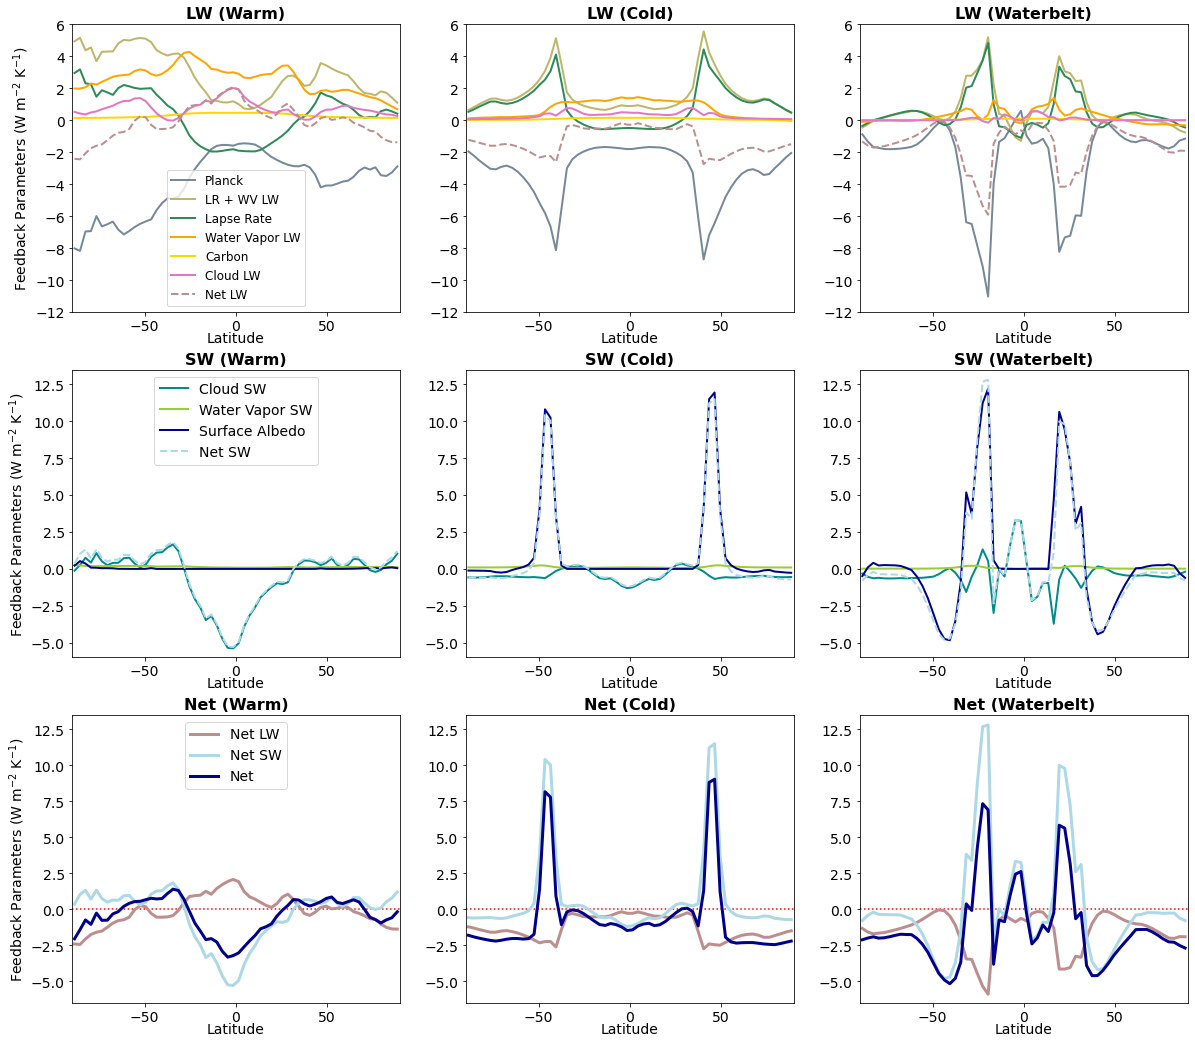

In [17]:
exp = ['warm_test16_1250','cold_950','waterbelt_550']
fig, axs = plt.subplots(3, 3, figsize=(20,18))
for i in range(len(exp)):
    for x in range(len(oned_list_LW)):
        item = oned_list_LW[x]
        var = plist[exp[i]+item]
        var = np.where(np.isnan(var), 0., var)
        # zonal average    
        ny = 60
        kernel, ylat, area = zonalKernel(grid_atm,ny) 
        var_zonal = zonalAvg(var,kernel)
        if item == 'feedback_integrated_LW':
            axs[0,i].plot(ylat, var_zonal, linewidth=2, linestyle='--', color=color_LW[x], label=label_LW[x])
        else:
            axs[0,i].plot(ylat, var_zonal, linewidth=2, color=color_LW[x], label=label_LW[x])
    axs[0,i].set_xlim(-90,90)
    axs[0,i].set_ylim(-12,6)
    axs[0,i].set_title('LW '+label[i], fontsize=16, fontweight='bold')
    axs[0,i].set_xlabel('Latitude', fontsize=14, labelpad=-2)
    axs[0,0].set_ylabel('Feedback Parameters (W m$^{-2}$ K$^{-1}$)', fontsize=14)
    axs[0,0].legend(fontsize=12)
    axs[0,i].tick_params(axis='both', which='major', labelsize=14)
    for x in range(len(oned_list_SW)):
        item = oned_list_SW[x]
        var = plist[exp[i]+item]
        var = np.where(np.isnan(var), 0., var)
        # zonal average    
        ny = 60
        kernel, ylat, area = zonalKernel(grid_atm,ny) 
        var_zonal = zonalAvg(var,kernel)
        if item == 'feedback_integrated_SW':
            axs[1,i].plot(ylat, var_zonal, linewidth=2, linestyle='--', color=color_SW[x], label=label_SW[x])
        else:
            axs[1,i].plot(ylat, var_zonal, linewidth=2, color=color_SW[x], label=label_SW[x])
    axs[1,i].set_xlim(-90,90)
    axs[1,i].set_ylim(-6,13.5)
    axs[1,i].set_title('SW '+label[i], fontsize=16, fontweight='bold')
    axs[1,i].set_xlabel('Latitude', fontsize=14, labelpad=-2)
    axs[1,0].set_ylabel('Feedback Parameters (W m$^{-2}$ K$^{-1}$)', fontsize=14)
    axs[1,0].legend(loc='upper center', fontsize=14)
    axs[1,i].tick_params(axis='both', which='major', labelsize=14)
    for x in range(len(oned_list_net)):
        item = oned_list_net[x]
        var = plist[exp[i]+item]
        var = np.where(np.isnan(var), 0., var)
        # zonal average    
        ny = 60
        kernel, ylat, area = zonalKernel(grid_atm,ny) 
        var_zonal = zonalAvg(var,kernel)
        axs[2,i].plot(ylat, var_zonal, linewidth=3, color=color_net[x], label=label_net[x])
    axs[2,i].hlines(y=0., xmin=-90, xmax=90, colors='r', linestyles='dotted')
    axs[2,i].set_xlim(-90,90)
    axs[2,i].set_ylim(-6.5,13.5)
    axs[2,i].set_title('Net '+label[i], fontsize=16, fontweight='bold')
    axs[2,i].set_xlabel('Latitude', fontsize=14, labelpad=-2)
    axs[2,0].set_ylabel('Feedback Parameters (W m$^{-2}$ K$^{-1}$)', fontsize=14)
    axs[2,0].legend(loc='upper center', fontsize=14)
    axs[2,i].tick_params(axis='both', which='major', labelsize=14)
# os.chdir('/nfs/home11/grad/2017/fz172169/0notebook')
# fig.savefig('feedback_lineplots.pdf')

## Plot spatial (2-D) maps

In [18]:
level_list = ['delta_T',
              'delta_T_minus_surfT',
              'feedback_T_LW',
              'feedback_P_LW',
              'feedback_L_LW',
              'delta_Q',
              'feedback_Q_LW',
              'feedback_Q_SW',
              'delta_CLDCLW',
             ]

limit = {}
level = {}
limit['delta_TS'] = [-0.1,0.4]
limit['delta_T'] = [-1.,3.5]
limit['delta_surfT'] = [-1.3,5.]
limit['delta_T_minus_surfT'] = [-2.4,1.6]
limit['feedback_T_LW'] = [-1.,0.4]
limit['feedback_P_LW'] = [-0.8,0.1]
limit['feedback_L_LW'] = [-0.8,1.]
limit['feedback_surfT_LW'] = [-5.2,0.5]
limit['delta_Q'] = [-0.2,1.]
limit['feedback_Q_LW'] = [-0.15,1.15]
limit['feedback_Q_SW'] = [-0.01,0.09]
limit['delta_ALB'] = [-0.1,0.065]
limit['feedback_ALB_SW'] = [-5.5,12.6]
limit['delta_CO2'] = [5.,50.]
limit['feedback_CO2_LW'] = [0.,0.48]
limit['delta_CLDCLW'] = [-0.016,0.019]
limit['delta_CRF_LW'] = [-1.8,3.2]
limit['feedback_cld_LW'] = [-0.2,2.1]
limit['delta_CRF_SW'] = [-20.,19.]
limit['feedback_cld_SW'] = [-5.8,3.6]

for item in level_list:
    level[item] = np.arange(limit[item][0], limit[item][1], (limit[item][1]-limit[item][0])/10)

plot_delta = ['delta_T',
              'delta_surfT',
              'delta_Q',
              'delta_ALB',
              'delta_CLDCLW',
             ]
plot_feedback = [#'feedback_T_LW',
                 'feedback_P_LW',
                 'feedback_L_LW',
                 'feedback_surfT_LW',
                 'feedback_Q_LW',
                 'feedback_Q_SW',
                 #'feedback_ALB_SW',
                 #'feedback_CO2_LW',
                ]

unit = {}
unit['delta_T'] = 'K K$^{-1}$'
unit['delta_surfT'] = 'K K$^{-1}$'
unit['delta_Q'] = 'g/kg K$^{-1}$'
unit['delta_ALB'] = 'K$^{-1}$'
unit['delta_CLDCLW'] = 'K$^{-1}$'
unit['delta_CRF'] = 'W m$^{-2}$ K$^{-1}$'

label_title = {}
label_title['delta_T'] = 'Air T Change '
label_title['delta_surfT'] = 'Surf. T Change '
label_title['delta_Q'] = 'WV Change '
label_title['delta_ALB'] = 'Albedo Change '
label_title['delta_CLDCLW'] = 'Cloud Change '
label_title['delta_CRF'] = 'CRF Change '

label_title['feedback_P_LW'] = 'Planck Feedback '
label_title['feedback_L_LW'] = 'LR Feedback '
label_title['feedback_surfT_LW'] = 'Surf. T Feedback '
label_title['feedback_Q_LW'] = 'WV LW Feedback '
label_title['feedback_Q_SW'] = 'WV SW Feedback '

label_state=['(Warm)',
             '(Cold)',
             '(Waterbelt)',
            ]

In [27]:
def plot_cloud(item): 
    item_LW = item+'_LW'
    item_SW = item+'_SW'
    for j in range(len(exp)):
        var_LW = plist[exp[j]+item_LW]
        var_SW = plist[exp[j]+item_SW]
        var_LW = np.where(np.isnan(var_LW), 0., var_LW)
        var_SW = np.where(np.isnan(var_SW), 0., var_SW)
        # zonal average    
        ny = 60
        kernel, ylat, area = zonalKernel(grid_atm,ny) 
        var_LW_zonal = zonalAvg(var_LW,kernel)
        var_SW_zonal = zonalAvg(var_SW,kernel)
        axs[j].plot(ylat, var_LW_zonal, color='darkorange', linewidth=2, label=item_LW)
        axs[j].plot(ylat, var_SW_zonal, color='darkblue', linewidth=2, label=item_SW)
        axs[j].hlines(y=0., xmin=-90, xmax=90, colors='r', linestyles='dotted')
        axs[j].set_xlim(-90,90)
        axs[j].legend(loc='best', fontsize=12)
        axs[j].set_ylim(min(limit[item_LW][0],limit[item_SW][0]), max(limit[item_LW][1],limit[item_SW][1]))
        axs[j].set_xlabel('Latitude', fontsize=14, labelpad=-1)
        axs[0].set_ylabel(unit[item], fontsize=14, labelpad=23)
        axs[j].set_title(label_title[item]+label_state[j], fontsize=15, fontweight='bold')
        axs[j].tick_params(axis='both', which='major', labelsize=12)

## Plot delta

In [20]:
def plot_spatial_delta(item, exp):       
    if plist[exp[0]+item].ndim == 3:
        for j in range(len(exp)):
            var = plist[exp[j]+item]
            var = np.where(np.isnan(var), 0., var)
            nlev = var.shape[0] 
            # mass weighted
            drF = grid_atm['drF']
            for k in range(nlev):
                var[k,:,:] = var[k,:,:]/(drF[k]*1E-4)
            # zonal average    
            ny = 60
            kernel, ylat, area = zonalKernel(grid_atm,ny) 
            var_zonal = np.zeros((nlev,ny))
            for k in range(nlev):
                var_zonal[k,:] = zonalAvg(var[k,:,:],kernel)
            lev = grid_atm['Z'][0:nlev]/100.
            y, z = np.meshgrid(ylat, lev)
            c=axs[j].contourf(y, z, var_zonal, levels=level[item], extend='both', cmap='PRGn')
            axs[j].contour(y, z, var_zonal, levels=[0.], linewidths=2, colors='wheat')
            #cbar = fig.colorbar(c, ax=axs[i,j], orientation='vertical')
            axs[j].invert_yaxis()
            axs[0].set_xlabel('Latitude', fontsize=14)
            axs[0].set_ylabel('hPa', fontsize=14, labelpad=29)
            axs[j].set_xlim(-90,90)
            axs[j].set_title(label_title[item]+label_state[j], fontsize=15, fontweight='bold')
            axs[j].tick_params(axis='both', which='major', labelsize=12)
        fig.subplots_adjust(bottom=0.2)
        cax = fig.add_axes([0.28, 0.075, 0.47, 0.04])
        cbar = fig.colorbar(c, cax=cax, orientation='horizontal')
        cbar.set_label(unit[item], fontsize=14, fontweight='bold', labelpad=-15, x=1.1)
        cbar.ax.tick_params(labelsize=12)
    
    elif plist[exp[0]+item].ndim == 2:
        for j in range(len(exp)):
            var = plist[exp[j]+item]
            var = np.where(np.isnan(var), 0., var)
            # zonal average    
            ny = 60
            kernel, ylat, area = zonalKernel(grid_atm,ny) 
            var_zonal = zonalAvg(var,kernel)
            axs[j].set_xlabel('Latitude', fontsize=14, labelpad=-1)
            #axs[0].set_ylabel(unit[item], fontsize=14)
            axs[j].plot(ylat, var_zonal, color='k', linewidth=2)
            axs[j].hlines(y=0., xmin=-90, xmax=90, colors='r', linestyles='dotted')
            axs[j].set_xlim(-90,90)
            axs[j].set_ylim(limit[item])
            axs[j].set_title(label_title[item]+label_state[j], fontsize=15, fontweight='bold')
            axs[j].tick_params(axis='both', which='major', labelsize=12)
        if item == 'delta_surfT':
            axs[0].set_ylabel(unit[item], fontsize=14, labelpad=32)
        else:
            axs[0].set_ylabel(unit[item], fontsize=14)

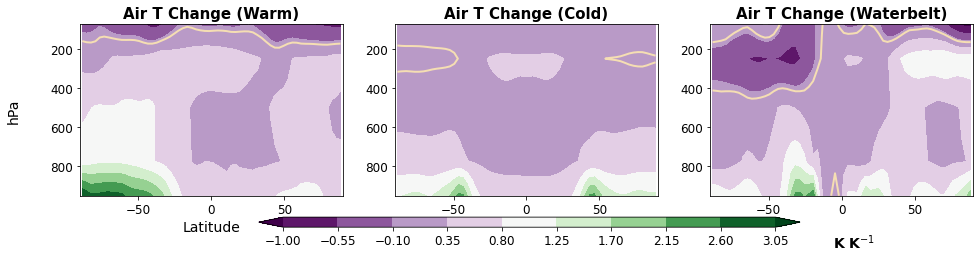

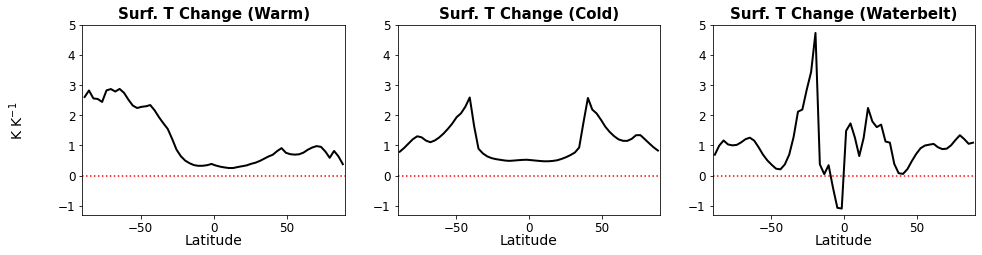

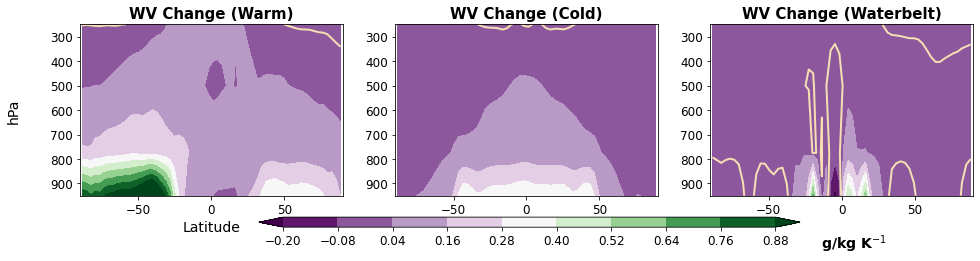

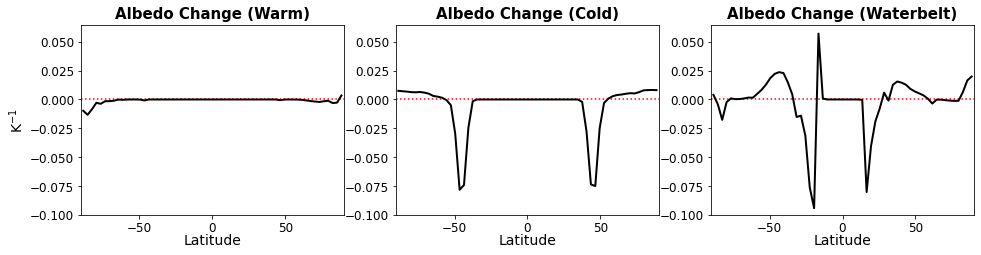

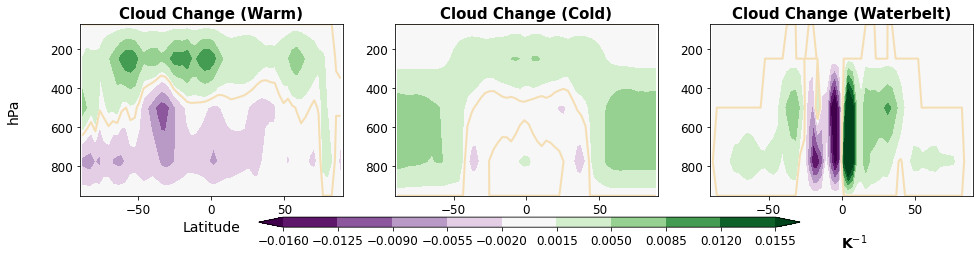

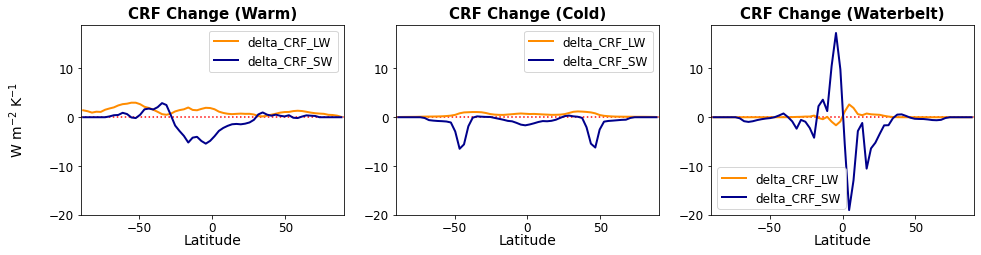

In [21]:
os.chdir('/nfs/home11/grad/2017/fz172169/0notebook')
exp = ['warm_test16_1250','cold_950','waterbelt_550']
for i in range(len(plot_delta)):
    fig, axs = plt.subplots(1, 3, figsize=(16,3.5))
    plot_spatial_delta(plot_delta[i], exp)
#     fig.savefig(plot_delta[i]+'.pdf')
    
fig, axs = plt.subplots(1, 3, figsize=(16,3.5))
plot_cloud('delta_CRF')
# fig.savefig('delta_CRF.pdf')

## Plot feedback

In [22]:
def plot_spatial_feedback(item, exp):       
    if plist[exp[0]+item].ndim == 3:
        for j in range(len(exp)):
            var = plist[exp[j]+item]
            var = np.where(np.isnan(var), 0., var)
            nlev = var.shape[0] 
            # mass weighted
            drF = grid_atm['drF']
            for k in range(nlev):
                var[k,:,:] = var[k,:,:]/(drF[k]*1E-4)
            # zonal average    
            ny = 60
            kernel, ylat, area = zonalKernel(grid_atm,ny) 
            var_zonal = np.zeros((nlev,ny))
            for k in range(nlev):
                var_zonal[k,:] = zonalAvg(var[k,:,:],kernel)
            lev = grid_atm['Z'][0:nlev]/100.
            y, z = np.meshgrid(ylat, lev)
            c=axs[j].contourf(y, z, var_zonal, levels=level[item], extend='both', cmap='PRGn')
            axs[j].contour(y, z, var_zonal, levels=[0.], linewidths=2, colors='wheat')
            #cbar = fig.colorbar(c, ax=axs[i,j], orientation='vertical')
            axs[j].invert_yaxis()
            axs[0].set_xlabel('Latitude', fontsize=14)
            axs[0].set_ylabel('hPa', fontsize=14, labelpad=29)
            axs[j].set_xlim(-90,90)
            axs[j].set_title(label_title[item]+label_state[j], fontsize=15, fontweight='bold')
            axs[j].tick_params(axis='both', which='major', labelsize=12)
        fig.subplots_adjust(bottom=0.2)
        cax = fig.add_axes([0.315, 0.075, 0.4, 0.04])
        cbar = fig.colorbar(c, cax=cax, orientation='horizontal')
        cbar.set_label('W m$^{-2}$ K$^{-1}$', fontsize=14, fontweight='bold', labelpad=-15, x=1.15)
        cbar.ax.tick_params(labelsize=12)
    
    elif plist[exp[0]+item].ndim == 2:
        for j in range(len(exp)):
            var = plist[exp[j]+item]
            var = np.where(np.isnan(var), 0., var)
            # zonal average    
            ny = 60
            kernel, ylat, area = zonalKernel(grid_atm,ny) 
            var_zonal = zonalAvg(var,kernel)
            axs[j].set_xlabel('Latitude', fontsize=14, labelpad=-1)
            #axs[0].set_ylabel(unit[item], fontsize=14)
            axs[j].plot(ylat, var_zonal, color='k', linewidth=2)
            axs[j].hlines(y=0., xmin=-90, xmax=90, colors='r', linestyles='dotted')
            axs[j].set_xlim(-90,90)
            axs[j].set_ylim(limit[item])
            axs[j].set_title(label_title[item]+label_state[j], fontsize=15, fontweight='bold')
            axs[j].tick_params(axis='both', which='major', labelsize=12)
        #if item == 'delta_surfT':
            axs[0].set_ylabel('W m$^{-2}$ K$^{-1}$', fontsize=14, labelpad=32)
        #else:
            #axs[0].set_ylabel(unit[item], fontsize=14)

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.


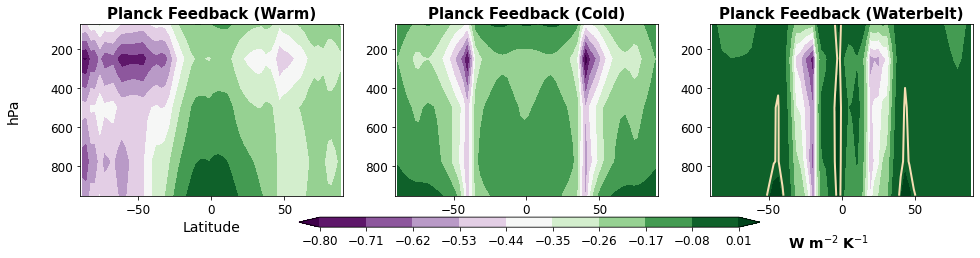

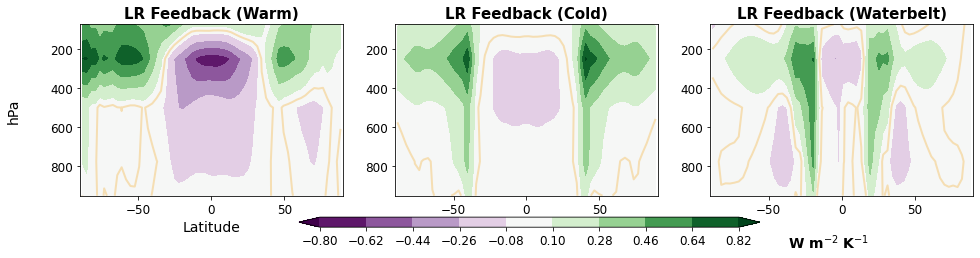

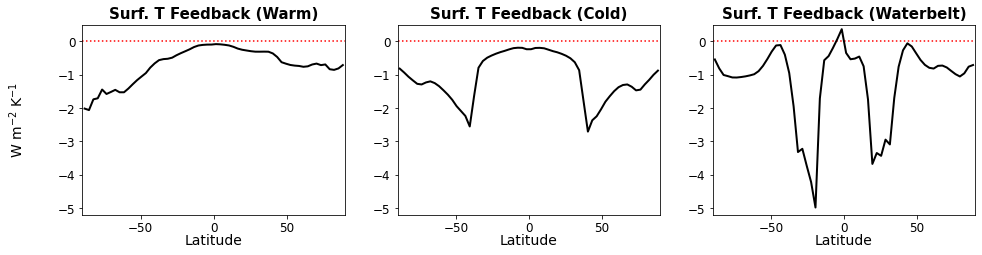

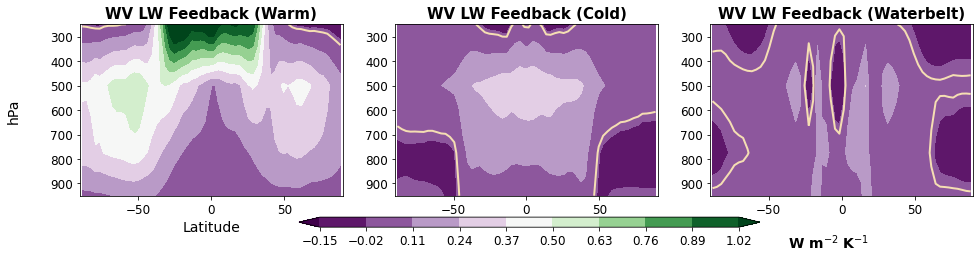

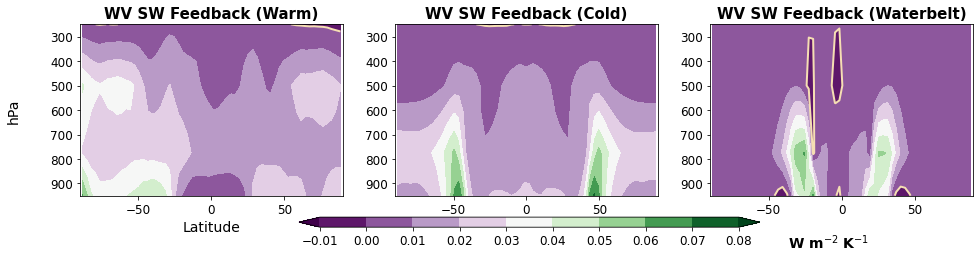

In [28]:
os.chdir('/nfs/home11/grad/2017/fz172169/0notebook')
exp = ['warm_test16_1250','cold_950','waterbelt_550']
for i in range(len(plot_feedback)):
    fig, axs = plt.subplots(1, 3, figsize=(16,3.5))
    plot_spatial_feedback(plot_feedback[i], exp)
#     fig.savefig(plot_feedback[i]+'.pdf')
    
# fig, axs = plt.subplots(1, 3, figsize=(16,3.5))
# plot_cloud('feedback_cld')
#fig.savefig('feedback_cld.pdf')